#### How long does it take for a loan to be fully funded? A prediction using supervised machine learning
Given this estimation, a borrower can adjust his plan and make informed decisions about when to apply for the loan, how much to borrow, and whether to explore alternative funding options to meet their financial needs more effectively. Additionally, understanding the expected funding timeline can help borrowers manage their expectations and improve their overall financial planning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import shap

pd.set_option('display.max_rows', 50)

c:\Users\ADMIN\Downloads\MSc Business Data Science\bds_assignment\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Data Loading and Preprocessing

In [2]:
## -------------- Load data --------------------
loan_data = [pd.read_csv(f'https://github.com/minh221/AAU_MSc_BDS/raw/main/m1/data/kiva_data_{i}.zip') for i in [1,2]]
iso = pd.read_csv('https://raw.githubusercontent.com/minh221/AAU_MSc_BDS/main/m1/data/iso_3166.csv')
mpi = pd.read_csv('https://raw.githubusercontent.com/aaubs/ds-master/main/data/assignments_datasets/KIVA/kiva_mpi_region_locations.csv')
## concat all parts of kiva_loan_data
df = pd.concat(loan_data)

## ------------- Clean loan data ----------------
df = df.dropna(subset=['loan_amount', 'sector', 'term_in_months', 'lender_count', 'repayment_interval'])

## calculate time for a loan to be fully funded
date_cols = ['disbursed_time', 'funded_time']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])
df['days_fully_funded'] = np.ceil((df['funded_time'] - df['disbursed_time']) / np.timedelta64(1, 'D'))

## remove outliers in loan amount using IQR method
Q1 = np.percentile(df['loan_amount'], 25, method='midpoint')
Q3 = np.percentile(df['loan_amount'], 75, method='midpoint')
IQR = Q3 - Q1
upper = Q3 + 1.5*IQR
lower = Q1 - 1.5*IQR
df = df[(df['loan_amount'] < upper) & (df['loan_amount'] > lower)]

## remove column with days to fully funded < 0
df = df[df['days_fully_funded'] > 0]

## ---------------- Select the nessesary columns ---------------
data = df.rename(columns={'country_code':'alpha-2'})
iso = iso[['name', 'alpha-2', 'alpha-3']].rename(columns={'name':'country'})
mpi = mpi[['ISO','region', 'MPI']].dropna().drop_duplicates().rename(columns={'ISO':'alpha-3', 'MPI':'mpi_value'})
## mpi table does not have standard region name, and also the region name in loan data is not unanimous, so hard to map because there are so many exceptions
## therefore, using avg mpi by country
mpi_country = mpi.groupby('alpha-3')['mpi_value'].mean().reset_index() 

## ----------------- Join ----------------
data = data.merge(iso, on='alpha-2')
data = data.merge(mpi_country, on='alpha-3')
data = data.set_index('id')
data = data[['sector', 'loan_amount', 'term_in_months', 'lender_count', 'days_fully_funded', 'repayment_interval','mpi_value' ]]
data = data.dropna()
len(data)

495570

In [3]:
data.term_in_months.max()

np.float64(122.0)

In [3]:
data['repayment_interval'].unique()

array(['irregular', 'monthly', 'bullet', 'weekly'], dtype=object)

##### Feature Engineering

Hear, we will encode categorical features using ordinal encoding for repayment_enterval and one-hot encoding for sector.
For repayment intervals, we assign a higher value to shorter intervals, as they typically indicate a quicker return on investment for lenders. This approach reflects the reduced risk associated with loans that are repaid in shorter time frames, as it allows lenders to recoup their capital faster and decreases the likelihood of default.
- irregular (1): Lower value due to unpredictability and potential difficulty in financial planning.
- bullet (2): Potential risk for lenders as they only received money when loan is due
- monthly (3): Moderate value, commonly accepted and allows for budgeting.
- meekly (4): Higher value for frequency

In [4]:
interval_mapping = {
    'irregular': 1,
    "bullet": 2,
    "monthly": 3,
    "weekly": 4
}
# Perform ordinal encoding
data['repayment_interval'] = data['repayment_interval'].map(interval_mapping)

# one hot encoding
ohe = OneHotEncoder(sparse_output=False)
categorical_cols = ['sector']
one_hot_encoded_sector = ohe.fit_transform(data[categorical_cols])

In [5]:
## apply dimensionality reduction to encoded sector columns
pca = PCA(n_components=2)
principal_components = pca.fit_transform(one_hot_encoded_sector)

## standard scaling
std_scaler = StandardScaler()
scaled = std_scaler.fit_transform(data.drop(columns=['days_fully_funded', 'sector']))
x = np.concatenate((principal_components, scaled), axis=1)
X = pd.DataFrame(x, columns=['sector1', 'sector2', 'loan_amount', 'term_in_months', 
                             'lender_count', 'repayment_interval', 'mpi_value'], index=data.index)
X

,sector1,sector2,loan_amount,term_in_months,lender_count,repayment_interval,mpi_value
id,,,,,,,
653051,-0.515547,-0.647483,-0.575728,-0.057564,-0.243640,-1.090208,0.870857
653053,-0.068376,0.025974,0.126818,-0.211199,-0.082405,-1.090208,0.870857
653063,-0.065740,0.024782,-0.831200,-0.211199,-0.566110,-1.090208,0.870857
653084,-0.515547,-0.647483,-0.320257,0.249705,0.078831,1.000172,0.870857
653078,-0.081500,0.032190,-0.320257,0.249705,-0.566110,1.000172,0.870857
...,...,...,...,...,...,...,...
1340256,0.780212,-0.085370,-1.278275,0.096070,-1.130434,1.000172,0.870857
1340251,0.780212,-0.085370,-1.278275,0.096070,-1.130434,1.000172,0.662909
1340267,0.780212,-0.085370,-1.278275,0.096070,-1.130434,1.000172,0.870857


PCA: By reducing the dimensionality after one-hot encoding, PCA helps mitigate the curse of dimensionality, making the regression model more robust and less prone to overfitting
Standard Scaling: It standardizes the features to have zero mean and unit variance, which is important for many machine learning algorithms. This ensures all features are on a similar scale and prevents features with larger magnitudes from dominating the model training.

#### Model Selection and Training
Here, we try XGBoostRegressor and RandomForestRegressor

In [7]:
# Train test split
y = data['days_fully_funded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, model_xgb.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, model_xgb.predict(X_test)))

print(f"XGBRegressor Train RMSE: {train_rmse:.2f}")
print(f"XGBRegressor Test RMSE: {test_rmse:.2f}")

XGBRegressor Train RMSE: 11.85
XGBRegressor Test RMSE: 12.05


In [8]:
## Train RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))

print(f"Random Forest Regressor Train RMSE: {train_rmse:.2f}")
print(f"Random Forest Regressor Test RMSE: {test_rmse:.2f}")

Linear Regressor Train RMSE: 9.08
Linear Regressor  Test RMSE: 12.62


RandomForestRegressor performed better on the train set but is not that good when predicting unseen data.
XBGRegressor is more stable. For XGBR:
- Train RMSE = 11.85: model's predictions on the training dataset deviate from the actual values by an average of approximately 11.85 units.
- Test RMSE = 12.05: model's predictions on the test dataset deviate from the actual values by an average of approximately 12.05 units.

The average prediction error is about 11% of the total possible range (107). The close values of Train and Test RMSE indicate that the model generalizes reasonably well.

#### Performing GridSeachCV on XGBRegressor model

In [7]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6],
    'min_child_weight': [1, 3]
}

# Set up Grid Search
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', # Negative MSE because GridSearchCV maximizes the score
                           cv=5, 
                           verbose=1, # Use all available cores
                           n_jobs=-1)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_)**0.5)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200}
Best RMSE: 11.91311014549023


In [43]:
xgbr_optimized = XGBRegressor(learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=200)
xgbr_optimized.fit(X_train, y_train)

# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, xgbr_optimized.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, xgbr_optimized.predict(X_test)))

print(f"XGBRegressor Train RMSE: {train_rmse:.2f}")
print(f"XGBRegressor Test RMSE: {test_rmse:.2f}")

XGBRegressor Train RMSE: 11.68
XGBRegressor Test RMSE: 11.96


Model slightly improved in performance with lower RMSE in both train and test set 
from (11.85, 12.04) to (11.68, 11.96)

##### Explainability

In [46]:
features = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgbr_optimized.feature_importances_})

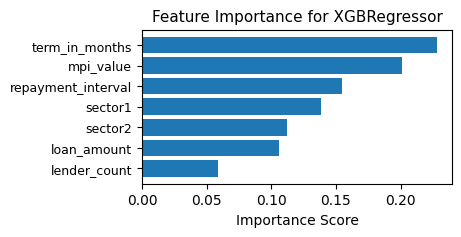

In [47]:
# Sort the DataFrame by importance
features = features.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(4, 2))
plt.barh(features['Feature'], features['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance for XGBRegressor', fontsize=11)
plt.yticks(fontsize=9)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

Loan term, mpi and repayment-interval are top 3 variables that have the highest influence on model decision. Next we look at SHAP value to see whether they affect the fully funded time positively or negatively

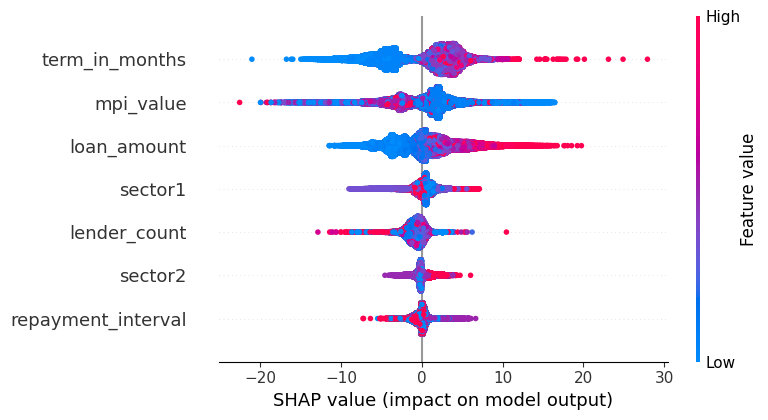

In [53]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(xgbr_optimized)
shap_values = explainer.shap_values(X_test)

# Plot SHAP values
shap.summary_plot(shap_values, X_test)

Though not quite clear, it can be seen from the chart that as the loan term  and loan amount increases, the model predicts a longer time for disbursement. The reason can be:
- Longer loan term and larger amount of money may require more due diligence from the lender, so that it take time
- Higher risk: Longer-term loans expose lenders to greater long-term risk, leading to more comprehensive evaluations. --> lenders have low risk appetite

MPI: high mpi, which indicate poor region, means it take longer for a loan to be fully disbursed. This can be associated with the fact that people are more hesitate to lend money to poor borrowers, which also links to risk appetite

In [54]:
## Save model to online app
import joblib

joblib.dump(xgbr_optimized, 'model.joblib')
joblib.dump(std_scaler, 'std_scaler.joblib')
joblib.dump(ohe, 'ohe.joblib')
joblib.dump(pca, 'pca.joblib')

['pca.joblib']